In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import pyaudio
import IPython.display as ipd
from PIL import Image
sr = 44100

In [2]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [3]:
x = np.linspace(1,15,1000)

time = 5
t = np.linspace(0,time, time*sr)
y = x

### Phase Diff

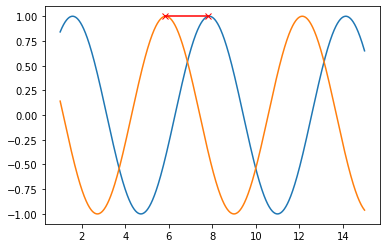

In [4]:
plt.ylim(-1.1,1.1)
plt.plot(x,np.sin(x))
plt.plot(y, np.sin(y+2))
plt.plot([5.8,5.8+2],[1,1], marker='x',c='r') #
printmd("### Phase Diff") 

### Less Amplitude

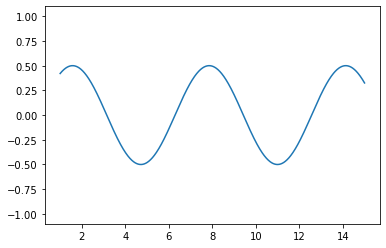

In [5]:
plt.ylim(-1.1,1.1)
plt.plot(x,np.sin(x)/2)
printmd("### Less Amplitude")

In [6]:
def pitch_to_freq(p):
     return np.power(2,(p-69)/12) * 440
    
print(pitch_to_freq(10000))

5.900107457068479e+251


### High Frequency

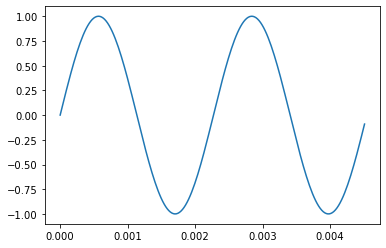

In [7]:
wave = np.sin(440 * 2 * np.pi * t)
plt.plot(t[:200],wave[:200])
printmd("### High Frequency")
ipd.Audio(wave,rate=sr)

c:\python38\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


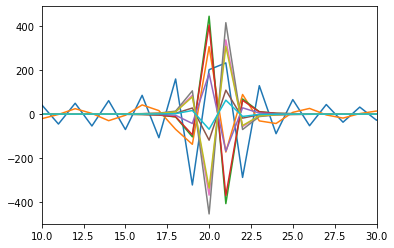

In [8]:
D = librosa.stft(wave)
plt.xlim(10,30)
plt.plot(D[:,:10])
plt.show()

In [9]:
import parselmouth #https://osf.io/umrjq/

In [10]:
snd = parselmouth.Sound("sounds\\A.wav") #Default sr = 44.1KHz
libsnd = librosa.load("sounds\\A.wav", sr=sr)

In [11]:
(libsnd[0] == snd).all()

True

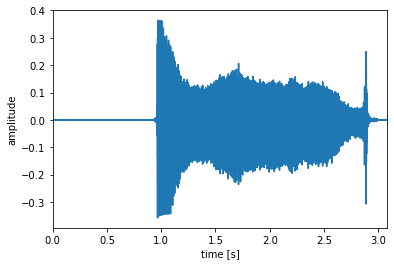

In [12]:
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show()
ipd.Audio(snd,rate=sr)

In [13]:
spectrogram = snd.to_spectrogram()
intensity = snd.to_intensity()
dynamic_range = 70

def draw_spectrogram(spectrogram, dynamic_range=70):
    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")
    
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")

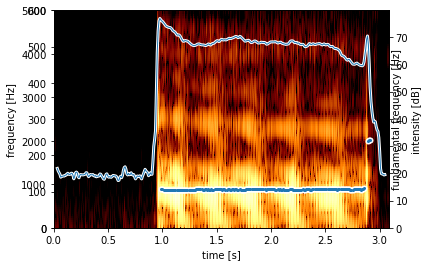

In [14]:
intensity = snd.to_intensity()
spectrogram = snd.to_spectrogram()
pitch = snd.to_pitch()

plt.figure()
draw_spectrogram(spectrogram)
plt.twinx()
draw_pitch(pitch)
plt.twinx()
draw_intensity(intensity)
plt.xlim([snd.xmin, snd.xmax])
plt.show()

![](formants.png)

In [15]:
def near_time(time, epsilon = 0.01):
    return np.array(np.where((intensity.xs() > time - epsilon) & (intensity.xs() < time + epsilon)))

def getdB(indexes, intensity):
    if(indexes.size == 0):
        return -1.0
    return intensity.values.T[indexes].ravel()

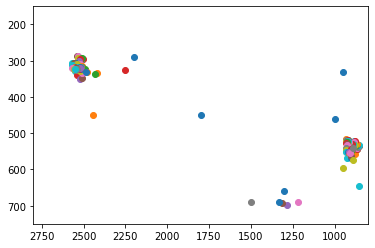

In [16]:
def scatter_formants(snd):
    formant = snd.to_formant_burg()
    intensity = snd.to_intensity()
    times_ = np.linspace(0.5,formant.time_range[1]- 0.1,100)

    plt.xlim(2800, 800)
    plt.ylim(750, 150)

    for i in times_:  
        f1 = formant.get_value_at_time(1, i)
        f2 = formant.get_value_at_time(2, i)
        if f1 > 700 or (f2 > 1600 and f1 > 600) or (getdB(near_time(i), intensity) < 40).all():
            continue

        plt.scatter(f2,f1)

f1s = [660, 450, 290, 460, 330]
f2s = [1300, 1800, 2200, 1000, 950]
plt.scatter(f2s,f1s)  

snd = parselmouth.Sound("sounds\\I.wav") #Default sr = 44.1KHz
scatter_formants(snd)
snd = parselmouth.Sound("sounds\\A.wav") #Default sr = 44.1KHz
scatter_formants(snd)
snd = parselmouth.Sound("sounds\\O.wav") #Default sr = 44.1KHz
scatter_formants(snd)
plt.show()